### Imports

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
import os 
path = os.path.dirname(os.path.realpath('main')) 
print(path)
import sys 
sys.path.insert (0, path)

/Users/amparoalias/Desktop/keepcoding-final-project/Notebooks


Importamos de "utils.py" las funciones que nos resumen la selección de variables que aplicaremos sobre train y test

In [4]:
import utils 
from utils import get_data_ready

In [5]:
from sklearn.decomposition import PCA
import pickle

In [6]:
import warnings
warnings.filterwarnings("ignore")

### Read data

In [7]:
data = pd.read_csv('../Datasets/merged_socialdata_placesinfo_starbucksdata.csv')

------

Usaremos para entrenar y validar el modelo solo aquellas zonas para las cuales tener tiendas de starbucks. Más adelante, este modelo se usará en las zonas sin starbucks para predecir donde funcionaría mejor y por lo tanto podría ponerse una tienda.

In [8]:
data.dropna(axis = 0, inplace = True)

Hacemos la división en train/test. 

Los storenumber que usamos para train los vamos a guardar en un .npy para usar el mismo train en todo el análisis tanto de la data demográfica como de la data de puntos de interés, ya que así nos aseguramos de no estar comentiendo data leakage.

In [9]:
#(train, test) = train_test_split(data, test_size=0.1, random_state=1)
#stores_for_train = train.storenumber.to_list()
#stores_for_test = test.storenumber.to_list()
#np.save('../Datasets/storenumbers_splitted/stores_for_train.npy', stores_for_train)
#np.save('../Datasets/storenumbers_splitted/stores_for_test.npy', stores_for_test)

--------

#### Read data for training/testing

In [36]:
stores_for_train = np.load('../Datasets/storenumbers_splitted/stores_for_train.npy')
stores_for_test = np.load('../Datasets/storenumbers_splitted/stores_for_test.npy')

In [37]:
train_data = data[data['storenumber'].isin(stores_for_train)]
test_data = data[data['storenumber'].isin(stores_for_test)]

#### Convertir a problema de clasificacion:

Looking at train: decidir a partir de cuando se considera que va bien el starbucks: (esto sería interesante hablarlo con los de negocio del Starbucks)

In [38]:
print("type: ", train_data['revenue'].dtype)
train_data['revenue'].describe()

type:  float64


count    1.590000e+02
mean     1.410107e+06
std      9.075243e+05
min      2.027340e+05
25%      6.454266e+05
50%      1.220818e+06
75%      2.050701e+06
max      4.257652e+06
Name: revenue, dtype: float64

<AxesSubplot:xlabel='revenue', ylabel='Density'>

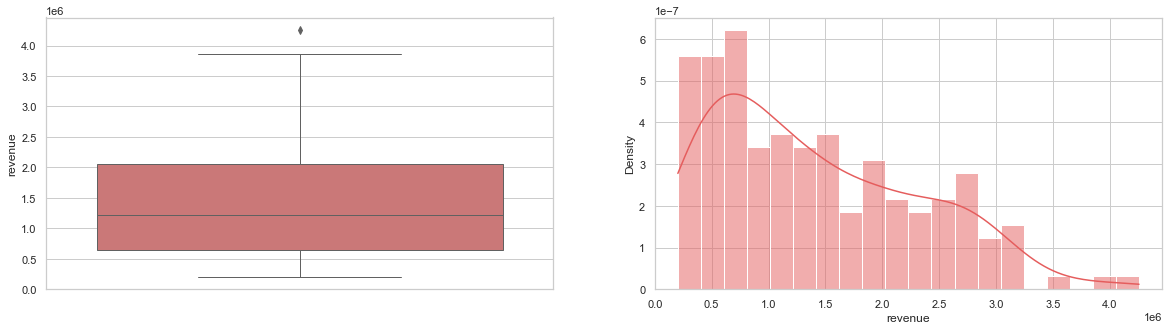

In [39]:
plt.subplots(nrows=1,ncols=2,figsize=(20,5))

plt.subplot(1,2,1)
sns.set_theme(style="whitegrid")
sns.boxplot(data=train_data, y='revenue', saturation = 0.6, linewidth = 1, color = '#E55D5D')
plt.subplot(1,2,2)
sns.set_theme(style="whitegrid")
sns.histplot(train_data['revenue'],color = '#E55D5D', bins = 20,kde = True, stat='density')

Consideraremos como punto de decisión de que el Starbucks va bien la mediana, ya que es más robusta que la media frente a outliers. De todas formas, como se ha comentado anteriormente, este punto sería interesante hablarlo con el experto de negocio de Starbucks.
<br> Esta función se usará más adelante tras hacer la limpieza de datos para convertir a un problema de clasificación.

In [40]:
def convert_to_classification_problem(df, median):
    for i in df.index:
        rev = df.loc[i, 'revenue']
        if rev < median:
            df.loc[i, 'revenue'] = 0
        else:
            df.loc[i, 'revenue'] =1
    return df

### Get TRAIN processed data

In [41]:
train_data = get_data_ready(train_data)
train_data.shape

(107, 27)

In [42]:
median = train_data['revenue'].median()
train_data = convert_to_classification_problem(train_data, median)
train_data['revenue'].value_counts()

1.0    54
0.0    53
Name: revenue, dtype: int64

In [43]:
to_drop = ['storenumber','geometry','Geographic Area Name']
train_data = train_data.drop(to_drop, axis = 1)

#for col in train_data.columns:
#    if col == 'Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)':
#        train_data.drop(train_data[train_data[col] == '-'].index, axis = 0, inplace = True)
#    if col == 'Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females)':
#        train_data.drop(train_data[train_data[col] == '-'].index, axis = 0, inplace = True)
#    if data[col].dtype == 'object':
#        train_data[col]=train_data[col].astype(float)

objective_var = 'revenue'
y_train = train_data[objective_var].values

df = train_data.drop(objective_var, axis = 1)
X_train = df.values 

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [44]:
pca = PCA(n_components=5)
pca.fit(X_train)
principalComponents = pca.transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])

In [45]:
pca.explained_variance_ratio_

array([0.61852128, 0.10835692, 0.05628181, 0.04373183, 0.04121572])

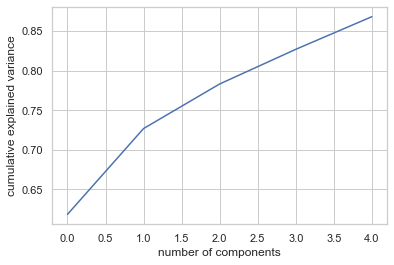

In [46]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [47]:
X_train = principalDf.values

### Get TEST processed data

In [48]:
test_data = get_data_ready(test_data)
test_data.shape

(17, 27)

In [49]:
#mantenemos la misma mediana que en train
test_data = convert_to_classification_problem(test_data, median)
test_data['revenue'].value_counts()

1.0    10
0.0     7
Name: revenue, dtype: int64

In [50]:
to_drop = ['storenumber','geometry','Geographic Area Name']
test_data = test_data.drop(to_drop, axis = 1)

#for col in test_data.columns:
#    if col == 'Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)':
#        test_data.drop(test_data[test_data[col] == '-'].index, axis = 0, inplace = True)
#    if col == 'Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females)':
#        test_data.drop(test_data[test_data[col] == '-'].index, axis = 0, inplace = True)
#    if test_data[col].dtype == 'object':
#        test_data[col]=test_data[col].astype(float)

        
objective_var = 'revenue'
y_test = test_data[objective_var].values


df = test_data.drop(objective_var, axis = 1)
X_test = df.values 


# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
X_test = scaler.transform(X_test) 

In [51]:
X_test = pca.transform(X_test)

### Model LogisticRegression with PCA

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression().fit(X_train,y_train)

In [53]:
train_predictions=model.predict(X_train)
accuracy_score(y_train, train_predictions)

0.8130841121495327

In [54]:
test_predictions=model.predict(X_test)
accuracy_score(y_test, test_predictions)

0.8235294117647058

              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77         7
         1.0       0.82      0.90      0.86        10

    accuracy                           0.82        17
   macro avg       0.83      0.81      0.81        17
weighted avg       0.82      0.82      0.82        17



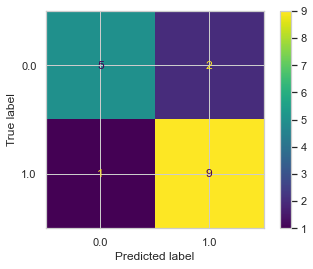

In [60]:
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

print(classification_report(y_test, test_predictions))
plot_confusion_matrix(model, X_test, y_test)
plt.show()

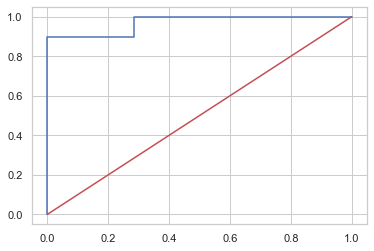

The AUC score is: 0.9714285714285714


In [59]:
probs = model.predict_proba(X_test)[:,1]

base_fpr, base_tpr,_ = roc_curve(y_test, [1 for _ in range(len(y_test))])
plt.plot(base_fpr, base_tpr, color = 'r')

fpr,tpr,_ = roc_curve(y_test, probs)
plt.plot(fpr,tpr)

plt.show()
print("The AUC score is:", roc_auc_score(y_test,probs))

### Model RandomForestClassifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import GridSearchCV

time of training: 12.75003695487976 seconds
best mean cross-validation score: 0.775
best parameters: {'max_depth': 1}


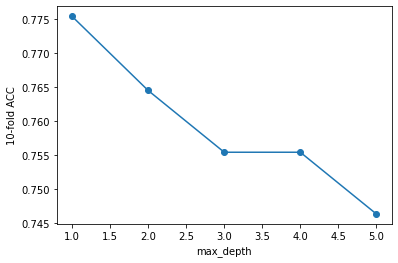

In [29]:
startTime = time.time()

# grid search
maxDepth = range(1,6)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

endTime = time.time()
print(f"time of training: {(endTime - startTime)} seconds")

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [30]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestClassifier(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.8130841121495327
Test:  0.7058823529411765


### Selección del mejor modelo:

Por accuracy en test vemos que la logisticRegression es la que mejor funciona.<br> Vamos a guardarlo para no tener que reentrenar cada vez:

In [31]:
#filename = 'models/logisticRegression'
#pickle.dump(grid, open(filename, 'wb'))

-------

Ahora podemos cargar el modelo ya entrenado y aplicarlo:

In [34]:
# load the model from disk
filename = 'models/logisticRegression'
model = pickle.load(open(filename, 'rb'))

Por lo que vamos a aplicar ahora el modelo entrenado para ver en que zonas de NY donde no hay starbucks sería interesante poner uno.

In [35]:
data = pd.read_csv('../Datasets/merged_socialdata_placesinfo_starbucksdata.csv')

In [36]:
data['geometry'] = data['geometry'].apply(wkt.loads)
data = geopandas.GeoDataFrame(data, geometry='geometry')
data.to_file('../Datasets/merged_socialdata_placesinfo_starbucksdata.geojson', driver="GeoJSON")

NameError: name 'wkt' is not defined

In [37]:
data_with_no_starbucks = data[data.revenue.isna()]

In [38]:
data_with_no_starbucks.shape

(163, 157)

Apply same data processing to this data

In [39]:
data_with_no_starbucks = get_data_ready(data_with_no_starbucks, future_prediction = True)

In [40]:
to_drop = ['revenue','storenumber','geometry','Geographic Area Name']
df = data_with_no_starbucks.drop(to_drop, axis = 1)

In [41]:
X = df.values 

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
X = scaler.transform(X) 

Apply PCA, with the same as in the train:

In [42]:
X = pca.transform(X)

Predict:

In [43]:
predictions=model.predict(X)

In [44]:
data_with_no_starbucks['predictions'] = predictions

In [45]:
data_with_no_starbucks['predictions'].value_counts()

1.0    107
0.0     56
Name: predictions, dtype: int64

In [49]:
#!pip install geopandas
import geopandas
from shapely import wkt

In [47]:
data_with_no_starbucks['geometry'] = data_with_no_starbucks['geometry'].apply(wkt.loads)
data_with_no_starbucks = geopandas.GeoDataFrame(data_with_no_starbucks, geometry='geometry')

NameError: name 'wkt' is not defined

In [ ]:
data_for_starbucks = data_with_no_starbucks[data_with_no_starbucks.predictions == 1.0]

data_for_starbucks['geometry'].plot()

In [ ]:
data_for_starbucks.to_file('../Datasets/predicted_future_zones_with_starbucks.geojson', driver="GeoJSON")

In [ ]:
filename = '../Models/starbucks_classifier.pkl'
with open(filename, 'wb') as fout:
    pickle.dump(model, fout) 
filename_pca = '../Models/starbucks_classifier_pca.pkl'
with open(filename_pca, 'wb') as fout:
    pickle.dump(pca, fout)   